In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.model_selection import train_test_split

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import acquire
import explore
import split_scale
import prep
import model

# Acquire the Data

In [2]:
df = acquire.get_zillow_data_from_sql()
# df = pd.read_csv('zillow.csv') # adding index_col=0 creates the unique row identifers

df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
0,11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.90
1,11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.69
2,14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.72
3,11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.19
4,11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.47


In [3]:
df.shape

(15036, 9)

In [4]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'square_feet', 'fips_number',
       'propertylandusetypeid', 'propertylandusedesc', 'home_value',
       'tax_amount'],
      dtype='object')

In [5]:
df .info()
# look like square_feet has some nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 9 columns):
parcelid                 15036 non-null int64
bathrooms                15036 non-null float64
bedrooms                 15036 non-null float64
square_feet              15012 non-null float64
fips_number              15036 non-null float64
propertylandusetypeid    15036 non-null int64
propertylandusedesc      15036 non-null object
home_value               15036 non-null float64
tax_amount               15035 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


### Takeaways from this 

- square_feet has null values
- tax_amount also has a null value
- propertylandusetypedesc should be a category
- given that there is a small number of nulls dropping the observations with missing values is a good way to go here

In [6]:
df.isnull().sum()

parcelid                  0
bathrooms                 0
bedrooms                  0
square_feet              24
fips_number               0
propertylandusetypeid     0
propertylandusedesc       0
home_value                0
tax_amount                1
dtype: int64

In [7]:
clean_df = prep.clean_data(df)
clean_df.isnull().sum()

# df.square_feet.value_counts(dropna=False)
# assert(df['square_feet'] >= 0 ).all()
# so this tells us we have some values that are less than zero 
# since we have an AssertionError we know there are some in our dataframe

parcelid                 0
bathrooms                0
bedrooms                 0
square_feet              0
fips_number              0
propertylandusetypeid    0
propertylandusedesc      0
home_value               0
tax_amount               0
dtype: int64

- used `prep.py` function clean_data to dropp all the overservations with missin values


In [8]:
clean_df.describe()

,parcelid,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,home_value,tax_amount
count,15011.0,15011.0,15011.0,15011.0,15011.0,15011.0,15011.0,15011.0
mean,13026849.8,2.3,3.3,1942.1,6049.4,261.0,541332.7,6593.3
std,3721599.4,1.0,0.9,1001.7,21.2,0.0,730626.4,8449.9
min,10712101.0,0.0,0.0,300.0,6037.0,261.0,10504.0,51.3
25%,11503044.5,2.0,3.0,1275.0,6037.0,261.0,198596.0,2706.5
50%,12581962.0,2.0,3.0,1679.0,6037.0,261.0,384886.0,4771.5
75%,14142703.0,3.0,4.0,2346.0,6059.0,261.0,644944.0,7678.3
max,167639152.0,11.0,12.0,15450.0,6111.0,261.0,23858374.0,276797.8


In [9]:
clean_df.shape

(15011, 9)

In [10]:
# set index to parcelid because each property has a unique number

df = clean_df .set_index(['parcelid'])
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
parcelid,,,,,,,,
11289917,2.0,3.0,1458.0,6037.0,261,Single Family Residential,136104.0,2319.9
11705026,1.0,2.0,1421.0,6037.0,261,Single Family Residential,35606.0,543.7
14269464,3.0,4.0,2541.0,6059.0,261,Single Family Residential,880456.0,9819.7
11389003,2.0,3.0,1650.0,6037.0,261,Single Family Residential,614000.0,7673.2
11967869,1.0,2.0,693.0,6037.0,261,Single Family Residential,274237.0,3267.5


# Check data again

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 11289917 to 11464823
Data columns (total 8 columns):
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null float64
fips_number              15011 non-null float64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null object
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.0+ MB


In [12]:
# so we need to change some of the datatypes. we can do this individually or all in one
df = df.astype(
    {'square_feet': 'int64',
     'propertylandusedesc': 'category'
    })

- change `square_feet` type to int64
- change `propertylandusedesc` to category

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 11289917 to 11464823
Data columns (total 8 columns):
bathrooms                15011 non-null float64
bedrooms                 15011 non-null float64
square_feet              15011 non-null int64
fips_number              15011 non-null float64
propertylandusetypeid    15011 non-null int64
propertylandusedesc      15011 non-null category
home_value               15011 non-null float64
tax_amount               15011 non-null float64
dtypes: category(1), float64(5), int64(2)
memory usage: 952.9 KB


In [14]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount
parcelid,,,,,,,,
11289917,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.9
11705026,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.7
14269464,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.7
11389003,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.2
11967869,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.5


In [15]:

df['county_name'] = df.fips_number.map({6037: 'Los Angeles', 
                                        6059: 'Orange',
                                        6111: 'Ventura'
                                       })


- added new column `county_name` to identify each properties location by using the `fips_number`

In [16]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name
parcelid,,,,,,,,,
11289917,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.9,Los Angeles
11705026,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.7,Los Angeles
14269464,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.7,Orange
11389003,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.2,Los Angeles
11967869,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.5,Los Angeles


In [17]:
df['distribution_of_tax_rates'] = df['tax_amount'] / df['home_value']
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name,distribution_of_tax_rates
parcelid,,,,,,,,,,
11289917,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.9,Los Angeles,0.0
11705026,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.7,Los Angeles,0.0
14269464,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.7,Orange,0.0
11389003,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.2,Los Angeles,0.0
11967869,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.5,Los Angeles,0.0


- added new column `distribution_of_tax_rates` which takes the `tax_amount` / `home_value`

In [18]:
# need to drop some columns 
df = df.drop(columns=['fips_number', 'propertylandusetypeid', 'propertylandusedesc',
                 'tax_amount', 'county_name', 'distribution_of_tax_rates'])

- drop some columns not needed for our modeling

In [19]:
df.head()

,bathrooms,bedrooms,square_feet,home_value
parcelid,,,,
11289917,2.0,3.0,1458,136104.0
11705026,1.0,2.0,1421,35606.0
14269464,3.0,4.0,2541,880456.0
11389003,2.0,3.0,1650,614000.0
11967869,1.0,2.0,693,274237.0


#  Visualize data distribution

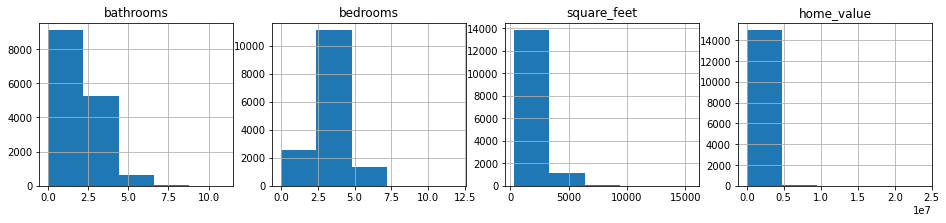

In [20]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(['bathrooms', 'bedrooms', 'square_feet', 'home_value']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(1,4, plot_number)
    plt.title(col)
    series.hist(bins=5)

# Splitting the data

In [21]:
# Define X and y variables
X = df[['bathrooms', 'bedrooms', 'square_feet']]
y = df[['home_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)

In [22]:
X_train.head()

,bathrooms,bedrooms,square_feet
parcelid,,,
11713180,3.0,2.0,1736
10774370,3.0,3.0,1565
12279758,2.0,3.0,1334
14476387,2.0,2.0,1503
10719724,2.0,3.0,1372


# Modeling

In [23]:
results = smf.ols('home_value ~ bedrooms + bathrooms + square_feet', data=df).fit()

In [24]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             home_value   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     3102.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:14:50   Log-Likelihood:            -2.2035e+05
No. Observations:               15011   AIC:                         4.407e+05
Df Residuals:                   15007   BIC:                         4.407e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.902e+04   1.73e+04     -1.674      

In [25]:
# Create Model
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=df).fit()

# Predict Model
ols_yhat = ols_model.predict(X_train)

In [26]:
# Create a DataFrame for evaluating my model(s) and Baseline Value
ols_eval = y_train.copy()
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [27]:
# Add Baseline Column
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [28]:
# Add Baseline
ols_eval['baseline_yhat'] = ols_eval['actual'].mean()

In [29]:
# Add OLS predictions columns
ols_eval['ols_yhat'] = ols_model.predict(X_train)

In [30]:
# Calculate and Add residuals colomns for plotting
ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual

In [31]:
# Compute the RMSE for our ols Model and Baseline using our created dataframe
baseline_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat))

ols_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat))
print(baseline_RMSE)
print(ols_RMSE)
print(f'My model has value: {ols_RMSE < baseline_RMSE}')

752417.9494731158
589415.467621281
My model has value: True


In [32]:
# Compute the RMSE for the model we created
ols_r2 = round(ols_model.rsquared,3)

ols_p_value = ols_model.f_pvalue

print(f'My R-squared score is significant: {ols_p_value < .05}')

My R-squared score is significant: True


In [33]:
ols_eval.head()

,actual,baseline_yhat,ols_yhat,residuals
parcelid,,,,
11713180,446597.0,547467.9,677810.2,231213.2
10774370,364898.0,547467.9,448062.6,83164.6
12279758,254856.0,547467.9,279033.4,24177.4
14476387,228954.0,547467.9,507829.1,278875.1
10719724,62074.0,547467.9,297120.9,235046.9


In [34]:
print(baseline_RMSE), print(ols_RMSE)

752417.9494731158
589415.467621281


(None, None)

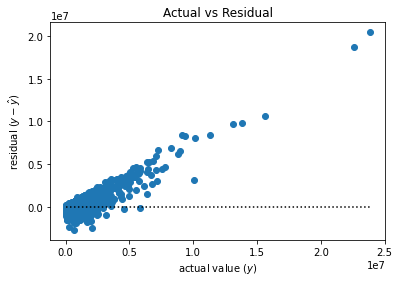

In [35]:
model.plot_residuals(ols_eval.actual, ols_eval.ols_yhat)

### Visualize Residuals

(array([1.000e+00, 3.000e+00, 6.000e+00, 2.300e+01, 5.800e+01, 2.240e+02,
        7.580e+02, 2.279e+03, 2.655e+03, 1.870e+02]),
 array([ 2.56175668,  3.78668763,  5.01161859,  6.23654954,  7.4614805 ,
         8.68641145,  9.91134241, 11.13627336, 12.36120432, 13.58613527,
        14.81106623]),
 <a list of 10 Patch objects>)

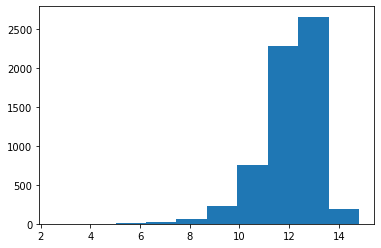

In [36]:
# create a histogram 
plt.hist(np.log(ols_eval.residuals))

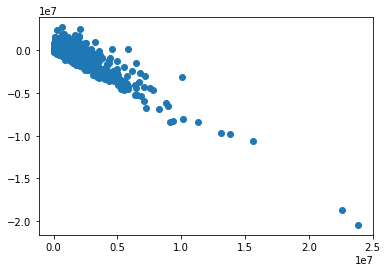

In [37]:
# create a scatter plot of the residuals and look for patters
plt.scatter(ols_eval.actual, ols_eval.residuals)

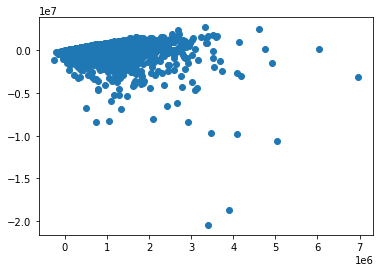

In [38]:
# look at predictions vs residuals
plt.scatter(ols_eval.ols_yhat, ols_eval.residuals)

In [39]:
model = lm().fit(X_train, y_train)

In [40]:
predictions = model.predict(X_test)

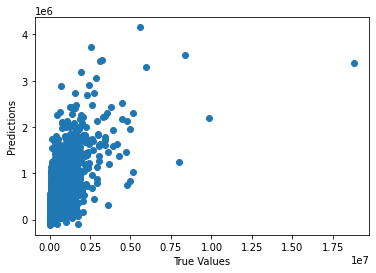

In [41]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()